# Introduction
This notebook has been created to demonstrate processing and analysis of public transportation data. The following data is used:
 - Translink public transport patronage data (January 2022 to August 2023)
 - Translink GTFS data
 - Locality boundaries spatial data 

## Python Libraries
This analysis uses the following libraries:
 - Pandas for data wrangling and queries
 - Geopandas for spatial processing

In [25]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Loading and Inspecting the Data
The parquet file loaded has been created using patronage data scraped from the Queensland Open Data website. To view the script used to obtain this information, please visit WEBSITE LINK.

As seen below, there is sufficient information to identify how many trips occurred from one stop to another. However, understanding trips between suburbs will be of more use to better understand general travel trends on public transport. This can be achieved by loading in locality boundaries and undertaking spatial analysis to locate the stops within the boundaries.

In [2]:
# Load trip data
df_trips = pd.read_parquet('./data/SEQ_PT_Trips.parquet')
df_trips['quantity'] = df_trips['quantity'].astype(int)

# Load stop information and remove unnecessary columns
df_stops = pd.read_csv('./data/stops.txt')
df_stops['stop_code'] = pd.to_numeric(df_stops['stop_code'], errors='coerce').fillna(-1).astype(int)
df_stops = df_stops.iloc[:, :7]

In [3]:
df_trips

,operator,month,route,direction,time,ticket_type,origin_stop,destination_stop,quantity
0,Transport for Brisbane,2022-01,175,Outbound,Weekend,go card,10309,2232,1
1,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,228,1308,1
2,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,6126,4
3,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,6027,9
4,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,5914,2
...,...,...,...,...,...,...,...,...,...
8835758,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1053,6
8835759,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1051,78
8835760,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1049,41
8835761,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1128,5


In [4]:
df_stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id
0,1,1,Herschel Street Stop 1 near North Quay,NaN,-27.467834,153.019079,1
1,10,10,Ann Street Stop 10 at King George Square,NaN,-27.468003,153.023970,1
2,100,100,Parliament Stop 94A Margaret St,NaN,-27.473751,153.026745,1
3,1000,1000,Handford Rd at Songbird Way,NaN,-27.339069,153.043907,2
4,10000,10000,Balcara Ave near Allira Cr,NaN,-27.344106,153.024982,2
...,...,...,...,...,...,...,...
13025,place_pinesc,-1,The Pines Shopping Centre,NaN,-28.134660,153.469767,NaN
13026,place_inttbl,-1,Toombul Shopping Centre interchange,NaN,-27.408269,153.059963,NaN
13027,place_scuniv,-1,University of the Sunshine Coast station,NaN,-26.718756,153.062004,NaN
13028,place_intuq,-1,UQ Chancellors Place,NaN,-27.497970,153.011136,NaN


## Spatial Analysis
Using the coordinates provided in the stops dataset, GeoPandas can be used to complete a join query to understand what stops are in within which locality boundaries. The boundaries spatial file was also sourced from the Queensland Open Data portal.

In [5]:
geometry = [Point(lon, lat) for lon, lat in zip(df_stops['stop_lon'], df_stops['stop_lat'])]
gdf_stops = gpd.GeoDataFrame(df_stops, geometry=geometry)

In [ ]:
gdf_stops.plot(marker='o', color='blue', markersize=1, figsize=(8, 8))
plt.title('GeoPandas Point Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
gdf_locality = gpd.read_file("./spatial/Locality_Boundaries.shp")

In [ ]:
m = gdf_locality.explore(color="blue")
gdf_stops.explore(m=m, column="stop_code", color="red")
folium.LayerControl().add_to(m)
m

In [9]:
gdf_stops.crs = "EPSG:4326"
gdf_stops = gdf_stops.to_crs(epsg=4283)
stops_loc = gdf_stops.sjoin(gdf_locality, how="inner", predicate="within")
stops_loc.head()
df_stops = stops_loc[['stop_id','stop_code','stop_name','stop_lat','stop_lon','zone_id','LOCALITY', 'LGA']]
df_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA
0,1,1,Herschel Street Stop 1 near North Quay,-27.467834,153.019079,1,Brisbane City,Brisbane City
1,10,10,Ann Street Stop 10 at King George Square,-27.468003,153.023970,1,Brisbane City,Brisbane City
2,100,100,Parliament Stop 94A Margaret St,-27.473751,153.026745,1,Brisbane City,Brisbane City
13,1001,1001,"Queen Street station, 1e",-27.470552,153.024575,1,Brisbane City,Brisbane City
22,1002,1002,"Queen Street station, 1f",-27.470675,153.024755,1,Brisbane City,Brisbane City
...,...,...,...,...,...,...,...,...
12047,600499,600499,"Traveston station, platform 1",-26.320895,152.783804,8,Traveston,Gympie Regional
12907,place_trvsta,-1,Traveston station,-26.321113,152.784072,NaN,Traveston,Gympie Regional
12049,600500,600500,"Gympie North station, platform 1",-26.159443,152.682805,8,Victory Heights,Gympie Regional
12835,place_gymsta,-1,Gympie North station,-26.159390,152.682995,NaN,Victory Heights,Gympie Regional


### An Example Query
We can now isoloate stops by their suburb.

In [10]:
df_stops[df_stops['LOCALITY'] == 'Bellbird Park']

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA
5234,310169,310169,Keidges Rd at Redbank Plains High School,-27.649570,152.871274,3,Bellbird Park,Ipswich City
5235,310171,310171,Redbank Plains Rd at Frangipanni Street,-27.630331,152.880053,3,Bellbird Park,Ipswich City
5236,310172,310172,Redbank Plains Rd at Brennan Street,-27.627919,152.885395,3,Bellbird Park,Ipswich City
5237,310173,310173,Redbank Plains Rd at Jayvilla Court,-27.628259,152.883961,3,Bellbird Park,Ipswich City
5238,310174,310174,Redbank Plains Rd at Len Shearer Park,-27.632205,152.875841,3,Bellbird Park,Ipswich City
5239,310175,310175,Redbank Plains Rd at Len Shearer Park,-27.632299,152.875167,3,Bellbird Park,Ipswich City
5240,310176,310176,"Redbank Plains Town Square, stop B",-27.645224,152.872001,3,Bellbird Park,Ipswich City
5241,310177,310177,Redbank Plains Rd at Shannon Street,-27.634633,152.873819,3,Bellbird Park,Ipswich City
8470,317741,317741,Redbank Plains Rd at Barry Drive,-27.637790,152.873259,3,Bellbird Park,Ipswich City
8502,317797,317797,Jones Rd near Augusta Pkwy,-27.647373,152.877792,3,Bellbird Park,Ipswich City


### Adding Locality Information to Trip Data

In [11]:
# Adding in origin locality
df_trips = df_trips.merge(df_stops[['stop_code', 'LOCALITY']], left_on='origin_stop', right_on='stop_code', how='left')
df_trips.drop('stop_code', axis=1, inplace=True)
df_trips.rename(columns={'LOCALITY': 'origin_loc'}, inplace=True)

# Adding in destination locality
df_trips = df_trips.merge(df_stops[['stop_code', 'LOCALITY']], left_on='destination_stop', right_on='stop_code', how='left')
df_trips.drop('stop_code', axis=1, inplace=True)
df_trips.rename(columns={'LOCALITY': 'destination_loc'}, inplace=True)

# Reordering df
df_trips = df_trips[['operator','month','route','direction','time','ticket_type','origin_stop','origin_loc','destination_stop','destination_loc','quantity']]

df_trips

,operator,month,route,direction,time,ticket_type,origin_stop,origin_loc,destination_stop,destination_loc,quantity
0,Transport for Brisbane,2022-01,175,Outbound,Weekend,go card,10309,Greenslopes,2232,Mount Gravatt,1
1,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,228,Fortitude Valley,1308,Manly West,1
2,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,6126,Manly West,4
3,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,6027,Tingalpa,9
4,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,5914,Murarrie,2
...,...,...,...,...,...,...,...,...,...,...,...
8835758,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1053,West End,6
8835759,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1051,West End,78
8835760,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1049,West End,41
8835761,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1128,West End,5


## Separating Origin and Destination Trip Data
The sourced datasets do not clearly show how many trips originate or terminate at a particular stop. We may wish to know this to understand questions such as "what is the busiest bus stop in the Brisbane CBD?" or "how did schedule works impact a given stop?".

The data can be aggregated by origin and destination to facilitate these queries.

In [16]:
# df_trips_o = df_trips.drop(['destination_stop'], axis=1)
df_trips_o = df_trips.groupby(['month', 'origin_stop','origin_loc'])['quantity'].sum().reset_index()
df_trips_o

,month,origin_stop,origin_loc,quantity
0,2022-01,1,Brisbane City,243
1,2022-01,2,Brisbane City,167
2,2022-01,3,Brisbane City,30
3,2022-01,4,Spring Hill,180
4,2022-01,5,Brisbane City,193
...,...,...,...,...
233194,2023-08,600829,Southport,35827
233195,2023-08,600831,Southport,61226
233196,2023-08,600832,Parkwood,6989
233197,2023-08,600834,Parkwood,19738


In [17]:
# df_trips_d = df_trips.drop(['origin_stop'], axis=1)
df_trips_d = df_trips.groupby(['month', 'destination_stop', 'destination_loc'])['quantity'].sum().reset_index()
df_trips_d

,month,destination_stop,destination_loc,quantity
0,2022-01,1,Brisbane City,350
1,2022-01,2,Brisbane City,758
2,2022-01,3,Brisbane City,1058
3,2022-01,4,Spring Hill,7
4,2022-01,5,Brisbane City,646
...,...,...,...,...
235889,2023-08,600829,Southport,37438
235890,2023-08,600831,Southport,56548
235891,2023-08,600832,Parkwood,6302
235892,2023-08,600834,Parkwood,18507


# Trip Analysis
The following outlines questions and the analysis to answer.

## Busiest periods
A plot showing the patronage by month shown below

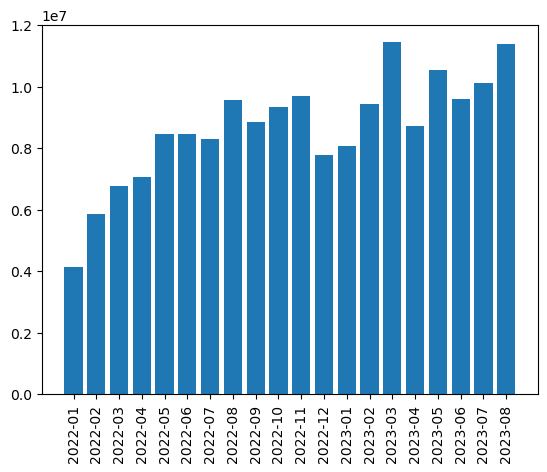

In [24]:
df_trip_totals = df_trips.groupby(['month'])['quantity'].sum().reset_index()

fig, ax = plt.subplots()
ax.bar(x=df_trip_totals['month'],height=df_trip_totals['quantity'])
ax.set_xticks(df_trip_totals['month'])
ax.set_xticklabels(df_trip_totals['month'], rotation=90)

plt.show()

## Travel between LGAs and Suburbs
- Interregional travel occurs the most between X and Y (SHOW IN A PLOT i.e. CORRELATION PLOT)
- These suburbs have the highest demand
- These hubs have the highest demand in the busiest locations - i.e. central in the city, demand outside of Brisbane, demand within suburbs

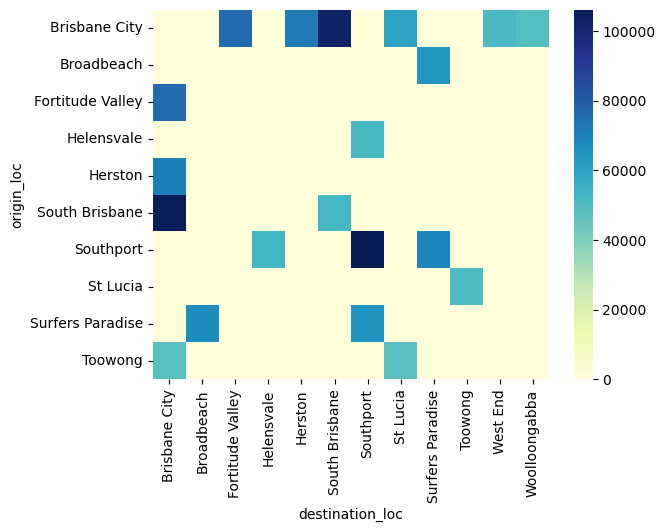

In [37]:
# Filter results by March 2023
df_trip_mar23 = df_trips[df_trips['month'] == '2023-03']

df_trip_top20 = df_trip_mar23.groupby(['month', 'origin_loc', 'destination_loc'])['quantity'].sum().reset_index()
df_trip_top20 = df_trip_top20.sort_values(by='quantity', ascending=False).head(20)
df_trip_top20

pivot_df = df_trip_top20.pivot_table(index='origin_loc', columns='destination_loc', values='quantity', fill_value=0)
sns.heatmap(pivot_df, cmap="YlGnBu")
plt.show()

# Future Work
The following will be undertaken:
- incorporation of additional data e.g. weather, economic measures, car ownership
- correlation analysis i.e. car ownership vs patronage